<a href="https://colab.research.google.com/github/hirobirofran/100knocks-preprocess-progress/blob/main/dotData%E6%A7%98%E8%AA%B2%E9%A1%8C_%E8%AA%B2%E9%A1%8C2_202503_fujino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 課題2. 顧客データから分析用データを作成するためのデータ変換パイプライン

## よく使うライブラリ

In [25]:
import os
import pandas as pd
import time
import psutil

## 定義値

In [26]:
# 定義値は必要に応じて変更して利用する

# 入力ファイル定義
INPUT_BASE_PATH: str = '/content/workspace/orig_data'
INPUT_SALES_FILE_NAME: str = 'cleaned_sales_data.csv'
INPUT_VENDOR_FILE_NAME: str = 'cleaned_vendor_data.csv'
INPUT_STORE_FILE_NAME: str = 'cleaned_store_data.csv'

# 出力ファイル定義
OUTPUT_BASE_PATH: str = '/content/workspace/analytic_data'
OUTPUT_SALES_FILE_NAME: str = 'sales_history.sql'
OUTPUT_VENDOR_FILE_NAME: str = 'vendor_master.sql'
OUTPUT_STORE_FILE_NAME: str = 'store_master.sql'
OUTPUT_SALES_GROWTH_FILE_NAME: str = 'sales_growth.sql'

# DB定義
SQLITE3_DB_FILENAME: str = 'sales_analysis.db'
SALES_TABLE_NAME: str = 'sales_history'
VENDOR_TABLE_NAME: str = 'vendors_master'
STORE_TABLE_NAME: str = 'stores_master'
SALES_GROWTH_TABLE_NAME: str = 'sales_growth'

# カラム定義
SALES_COLUMNS_STORE_STANDARDIZED_SALE: str = "Store_Standardized_Sale"
SALES_COLUMNS_CATEGORY_STANDARFIZED_SALE: str = "Category_Standardized_Sale"
SALES_COLUMNS = [
    "Date", "Store Number", "Category", "Category Name",
    "Vendor Number", "Item Number", "Item Description",
    "Bottle Volume (ml)", "Bottles Sold", "Volume Sold (Liters)",
    "Volume Sold (Gallons)", "Sale (Dollars)",
    SALES_COLUMNS_STORE_STANDARDIZED_SALE,
    SALES_COLUMNS_CATEGORY_STANDARFIZED_SALE
]
VENDOR_COLUMNS = ["Vendor Number", "Vendor Name"]
STORE_COLUMNS = ["Store Number", "Store Name", "Address", "Zip Code", "County Number", "County"]
SALES_GROWTH_COLUMNS = ["Store Number", "Category", "Date", "Daily_Sale", "Growth_Flag"]

# テーブル定義
SALES_TABLE_DEFINITION = f"""
-- 販売履歴
CREATE TABLE IF NOT EXISTS sales_history (
    "Date" DATE,                      -- 取引日（期間: 2020年11月から2024年10月）
    "Store Number" INT,               -- 店舗識別ID
    "Category" INT,                   -- 商品カテゴリ識別番号
    "Category Name" TEXT,             -- 商品カテゴリ名（例: Vodka, Whiskeyなど）
    "Vendor Number" INT,              -- ベンダー識別ID
    "Item Number" INT,                -- 商品識別ID
    "Item Description" TEXT,          -- 商品の説明（例: ブランド名や商品名）
    "Bottle Volume (ml)" INT,         -- ボトル1本あたりの容量（ミリリットル）
    "Bottles Sold" INT,               -- 取引で販売されたボトルの本数
    "Volume Sold (Liters)" DOUBLE,    -- 取引で販売された酒類の総容量（リットル）
    "Volume Sold (Gallons)" DOUBLE,   -- 取引で販売された酒類の総容量（ガロン）
    "Sale (Dollars)" DOUBLE,          -- 売上金額（ドル）
    {SALES_COLUMNS_STORE_STANDARDIZED_SALE} DOUBLE,
                                      -- 店舗ごとの平均値で標準化した売上金額
    {SALES_COLUMNS_CATEGORY_STANDARFIZED_SALE} DOUBLE
                                      -- 商品カテゴリごとの平均値で標準化した売上金額
);
"""
VENDOR_TABLE_DEFINITION = """
-- ベンダーマスタ
CREATE TABLE IF NOT EXISTS vendors_master (
    "Vendor Number" INT,  -- ベンダー識別ID
    "Vendor Name" TEXT,   -- ベンダー名前（商品供給元の企業やブランド名）
    PRIMARY KEY ("Vendor Number")
);
"""

STORE_TABLE_DEFINITION = """
-- 店舗マスタ
CREATE TABLE IF NOT EXISTS stores_master (
    "Store Number" INT,   -- 店舗識別ID
    "Store Name" TEXT,    -- 店舗名
    "Address" TEXT,       -- 店舗の所在地住所
    "Zip Code" INT,       -- 店舗の郵便番号
    "County Number" INT,  -- 店舗が所在する郡（County）の識別ID
    "County" TEXT,        -- 店舗が所在する郡（County）の名前
    PRIMARY KEY ("Store Number")
);
"""

SALES_GROWTH_TABLE_DEFINITION = """
-- 売上成長
CREATE TABLE IF NOT EXISTS sales_growth (
    "Store Number" INT,   -- 店舗識別ID
    "Category" INT,       -- 商品カテゴリ識別番号
    "Date" DATE,          -- 取引日（YYYY-MM-DD）
    "Daily_Sale" DOUBLE,  -- 日次売上金額（ドル）
    "Growth_Flag" INT,    -- １週間前と比較して10％以上売上が増加していたら1、そうでなければ0
    PRIMARY KEY ("Store Number", "Category", "Date")
);
"""

## データの読み込み

In [27]:
def load_input_data(
    input_base_path: str,
    sales_file_name: str,
    vendor_file_name: str,
    store_file_name: str
    ) -> str:
    """
    データ読み込み

    Args:
        input_base_path (str): クリーニング済み入力ファイルのパス
        sales_file_name (str): 販売履歴データファイル名
        vendor_file_name (str): ベンダーマスタファイル名
        store_file_name (str): 店舗マスタファイル名

    Returns:
        sales_data (pd.DataFrame): 販売履歴データ
        vendor_data (pd.DataFrame): ベンダーデータ
        store_data (pd.DataFrame): 店舗データ
    """

    sales_data = pd.read_csv(os.path.join(input_base_path, sales_file_name))
    vendor_data = pd.read_csv(os.path.join(input_base_path, vendor_file_name))
    store_data = pd.read_csv(os.path.join(input_base_path, store_file_name))
    return sales_data, vendor_data, store_data

## 販売履歴に分析用カラムを追加

In [28]:
def add_store_standardized_sales(data: pd.DataFrame) -> pd.DataFrame:
    """
    店舗ごとの平均値で標準化した売上金額を追加

    Args:
        data (pd.DataFrame): 販売履歴データ

    Returns:
        pd.DataFrame: 店舗ごとの標準化カラムを追加したデータ
    """
    store_avg = data.groupby('Store Number')['Sale (Dollars)'].transform('mean')
    data[SALES_COLUMNS_STORE_STANDARDIZED_SALE] = data['Sale (Dollars)'] / store_avg
    return data

def add_category_standardized_sales(data: pd.DataFrame) -> pd.DataFrame:
    """
    商品カテゴリごとの平均値で標準化した売上金額を追加

    Args:
        data (pd.DataFrame): 販売履歴データ

    Returns:
        pd.DataFrame: 商品カテゴリごとの標準化カラムを追加したデータ
    """
    category_avg = data.groupby('Category')['Sale (Dollars)'].transform('mean')
    data[SALES_COLUMNS_CATEGORY_STANDARFIZED_SALE] = data['Sale (Dollars)'] / category_avg
    return data

def process_sales_data(sales_data: pd.DataFrame) -> pd.DataFrame:
    """
    販売履歴データを読み込み、標準化したカラムを追加して保存

    Args:
        sales_data (pd.DataFrame): 販売履歴データ

    Returns:
        pd.DataFrame: 標準化したカラムを追加したデータフレーム
    """
    # 店舗ごとの標準化カラムを追加
    sales_data = add_store_standardized_sales(sales_data)

    # 商品カテゴリごとの標準化カラムを追加
    sales_data = add_category_standardized_sales(sales_data)

    return sales_data

## 「売上成長」作成

In [29]:
def calculate_daily_sales(data: pd.DataFrame) -> pd.DataFrame:
    """
    日次売上を計算

    Args:
        data (pd.DataFrame): 販売履歴データ

    Returns:
        pd.DataFrame: 日次売上を計算したデータフレーム
    """
    daily_sales = data.groupby(['Store Number', 'Category', 'Date'])['Sale (Dollars)'].sum().reset_index()
    daily_sales.rename(columns={'Sale (Dollars)': 'Daily_Sale'}, inplace=True)
    return daily_sales

def add_growth_flag(data: pd.DataFrame) -> pd.DataFrame:
    """
    1週間前の売上と比較して成長フラグを追加

    Args:
        data (pd.DataFrame): 日次売上データ

    Returns:
        pd.DataFrame: 成長フラグを追加したデータフレーム
    """
    data['Previous_Week_Sale'] = data.groupby(['Store Number', 'Category'])['Daily_Sale'].shift(7)
    data['Growth_Flag'] = (data['Daily_Sale'] > data['Previous_Week_Sale'] * 1.1).astype(int)
    data.drop(columns=['Previous_Week_Sale'], inplace=True)
    return data

def process_sales_growth(sales_data: pd.DataFrame) -> pd.DataFrame:
    """
    売上成長データを生成

    Args:
        sales_data (pd.DataFrame): 販売履歴データ

    Returns:
        pd.DataFrame: 売上成長データ
    """

    # 日次売上の計算
    daily_sales = calculate_daily_sales(sales_data)

    # 成長フラグの追加
    sales_growth_data = add_growth_flag(daily_sales)

    print("売上成長データの生成が完了しました")
    return sales_growth_data

## カラムが定義通りかをチェック

In [30]:
def validate_columns(data: pd.DataFrame, expected_columns: list, table_name: str) -> None:
    """
    データフレームのカラム構成が期待通りか検証する。

    Args:
        data (pd.DataFrame): データフレーム
        expected_columns (list): 期待されるカラム名のリスト
        table_name (str): テーブル名（検証対象）

    Raises:
        ValueError: カラムが期待値と一致しない場合
    """
    if not all(col in data.columns for col in expected_columns):
        raise ValueError(f'{table_name}のカラムが仕様と一致しません。')


    print(f'{table_name}のカラムチェックが完了しました')


## 分析用データの出力

In [31]:
import sqlite3

def create_tables_with_constraints(conn: sqlite3.Connection) -> None:
    """
    SQLiteに制約付きのテーブルを作成する。

    Args:
        conn (sqlite3.Connection): SQLiteデータベース接続オブジェクト。
    """
    cursor = conn.cursor()

    # sales_historyテーブルの作成
    cursor.execute(SALES_TABLE_DEFINITION)

    # vendors_masterテーブルの作成
    cursor.execute(VENDOR_TABLE_DEFINITION)

    # stores_masterテーブルの作成
    cursor.execute(STORE_TABLE_DEFINITION)

    # sales_growthテーブルの作成
    cursor.execute(SALES_GROWTH_TABLE_DEFINITION)

    conn.commit()

def insert_data_into_tables(
    conn: sqlite3.Connection,
    sales_data: pd.DataFrame,
    vendor_data: pd.DataFrame,
    store_data: pd.DataFrame,
    sales_growth_data: pd.DataFrame
    ) -> None:
    """
    データフレームから制約付きテーブルにデータを挿入。

    Args:
        conn (sqlite3.Connection): SQLiteデータベース接続オブジェクト。
        sales_data (pd.DataFrame): 販売履歴データ。
        vendor_data (pd.DataFrame): ベンダーデータ。
        store_data (pd.DataFrame): 店舗データ。
        sales_growth_data (pd.DataFrame): 売上成長データ。
    """
    sales_data.to_sql(SALES_TABLE_NAME, conn, if_exists="replace", index=False)
    vendor_data.to_sql(VENDOR_TABLE_NAME, conn, if_exists="replace", index=False)
    store_data.to_sql(STORE_TABLE_NAME, conn, if_exists="replace", index=False)
    sales_growth_data.to_sql(
        SALES_GROWTH_TABLE_NAME, conn, if_exists="replace", index=False)

def save_data(
    sales_data: pd.DataFrame,
    vendor_data: pd.DataFrame,
    store_data: pd.DataFrame,
    sales_growth_data: pd.DataFrame,
    ) -> None:
    """
    データ保存

    Args:
        sales_data: pd.DataFrame      : 販売履歴データ
        vendor_data: pd.DataFrame     : ベンダーデータ
        store_data: pd.DataFrame      : 店舗データ
        sales_growth_data: pd.DataFrame: 売上成長データ

    Returns:
        None
    """
    with sqlite3.connect(SQLITE3_DB_FILENAME) as conn:
        # 制約付きテーブルの作成
        create_tables_with_constraints(conn)

        # データの挿入
        insert_data_into_tables(
            conn, sales_data, vendor_data, store_data, sales_growth_data)

    print("データが制約付きのSQLiteテーブルに保存されました。")

def get_table_dump(conn: sqlite3.Connection, table_name: str) -> list:
    """
    指定されたテーブルのSQLダンプを取得。

    Args:
        conn (sqlite3.Connection): SQLiteデータベース接続。
        table_name (str): テーブル名。

    Returns:
        list: テーブル関連のSQLコマンド一覧。
    """
    dump_lines = []
    for line in conn.iterdump():
        if f'CREATE TABLE "{table_name}"' in line or f'INSERT INTO "{table_name}"' in line:
            dump_lines.append(line)
    return dump_lines

def save_dump_to_file(
    dump_lines: list,
    output_file: str) -> None:
    """
    SQLダンプを指定されたファイルに保存。

    Args:
        dump_lines (list): SQLダンプのリスト。
        output_file (str): 出力ファイルパス。

    Returns:
        None
    """
    with open(output_file, "w") as f:
        for line in dump_lines:
            f.write(f"{line}\n")

def export_table_to_sql_file(
    table_name: str,
    output_base_path: str,
    output_file: str) -> None:
    """
    テーブルごとにSQLファイルをエクスポート。

    Args:
        table_name (str): テーブル名。
        output_base_path (str): 出力ファイルのベースパス。
        output_file (str): 出力ファイル名。

    Returns:
        None
    """
    with sqlite3.connect(SQLITE3_DB_FILENAME) as conn:
        dump_lines = get_table_dump(conn, table_name)
        save_dump_to_file(dump_lines, os.path.join(output_base_path, output_file))

    print(f"Exported table {table_name} to {output_file}")

## 測定用

In [32]:
# メモリ使用量を測定
def memory_usage():
    """
    現在のプロセスのメモリ使用量を取得。

    Returns:
        float: メモリ使用量（MB単位）。
    """
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 ** 2

## 実行フロー

In [33]:
# 計測用
start_time = time.time()
start_memory = memory_usage()

# 顧客データ（課題1でクリーニング済み）の読み込み
sales_data, vendor_data, store_data = load_input_data(
    INPUT_BASE_PATH,
    INPUT_SALES_FILE_NAME, INPUT_VENDOR_FILE_NAME, INPUT_STORE_FILE_NAME)

# 販売履歴に分析用カラムを追加する
sales_data = process_sales_data(sales_data)

# 売上成長を作成
sales_growth_data = process_sales_growth(sales_data)

# 出力前に各テーブルのカラム名が定義通りかチェック
validate_columns(sales_data, SALES_COLUMNS, '販売履歴')
validate_columns(vendor_data, VENDOR_COLUMNS, 'ベンダーマスター')
validate_columns(store_data, STORE_COLUMNS, '店舗マスタ')
validate_columns(sales_growth_data, SALES_GROWTH_COLUMNS, '売上成長')

# 分析用データを出力
save_data(sales_data, vendor_data, store_data, sales_growth_data)
export_table_to_sql_file(
    SALES_TABLE_NAME, OUTPUT_BASE_PATH, OUTPUT_SALES_FILE_NAME)
export_table_to_sql_file(
    VENDOR_TABLE_NAME, OUTPUT_BASE_PATH, OUTPUT_VENDOR_FILE_NAME)
export_table_to_sql_file(
    STORE_TABLE_NAME, OUTPUT_BASE_PATH, OUTPUT_STORE_FILE_NAME)
export_table_to_sql_file(
    SALES_GROWTH_TABLE_NAME, OUTPUT_BASE_PATH, OUTPUT_SALES_GROWTH_FILE_NAME)

end_time = time.time()
end_memory = memory_usage()
print(f'Processing Time (s): {end_time - start_time}')
print(f'Memory Usage (MB): {end_memory - start_memory}')

売上成長データの生成が完了しました
販売履歴のカラムチェックが完了しました
ベンダーマスターのカラムチェックが完了しました
店舗マスタのカラムチェックが完了しました
売上成長のカラムチェックが完了しました
データが制約付きのSQLiteテーブルに保存されました。
Exported table sales_history to sales_history.sql
Exported table vendors_master to vendor_master.sql
Exported table stores_master to store_master.sql
Exported table sales_growth to sales_growth.sql
Processing Time (s): 17.50941014289856
Memory Usage (MB): 10.25


# 処理シミュレーション計測

元データの行数: 288737
テストデータの行数: 288737
元データの行数: 288737
テストデータの行数: 2887370
元データの行数: 288737
テストデータの行数: 14436850
元データの行数: 288737
テストデータの行数: 28873700
元データの行数: 288737
テストデータの行数: 43310550
   multiplier      Rows  Processing Time (s)  Memory Usage (MB)
0           1    288737             0.020136           0.000000
1          10   2887370             0.176304          82.128906
2          50  14436850             1.442442         220.382812
3         100  28873700             1.841308         440.687500
4         150  43310550             2.772681         661.082031


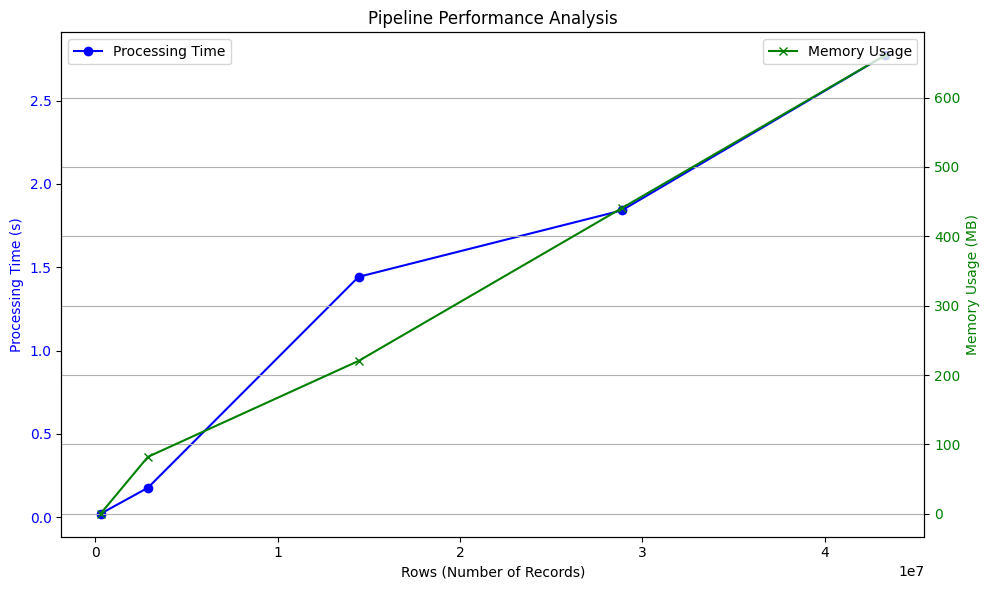

In [5]:

# 処理を重ねるためにデータを拡張（データ量を増加させる）
def expand_data(data, multiplier):
    """
    データを指定倍に拡張する。

    Args:
        data (pd.DataFrame): 元データ。
        multiplier (int): 拡張する倍率。

    Returns:
        pd.DataFrame: 拡張後のデータフレーム。
    """
    return pd.concat([data] * multiplier, ignore_index=True)

# パイプライン処理のシミュレーション
def process_pipeline(data):
    """
    パイプラインのシミュレーション処理を行う。

    Args:
        data (pd.DataFrame): 入力データ。

    Returns:
        pd.DataFrame: 処理済みデータフレーム。
    """
    # 店舗ごとの平均値で標準化
    data['Store_Standardized_Sale'] = data['Sale (Dollars)'] / data.groupby('Store Number')['Sale (Dollars)'].transform('mean')
    # 商品カテゴリごとの平均値で標準化
    data['Category_Standardized_Sale'] = data['Sale (Dollars)'] / data.groupby('Category')['Sale (Dollars)'].transform('mean')
    return data

# 顧客データ（課題1でクリーニング済み）の読み込み
sales_data, vendor_data, store_data = load_input_data(
    INPUT_BASE_PATH,
    INPUT_SALES_FILE_NAME, INPUT_VENDOR_FILE_NAME, INPUT_STORE_FILE_NAME)

# データ規模と処理時間を計測
results = []
multipliers = [1, 10, 50, 100, 150]  # データ拡張倍率（Colabだと200でクラッシュ）

for multiplier in multipliers:
    print(f"元データの行数: {len(sales_data)}")
    #print(f"元データのプレビュー:\n{sales_data.head()}")
    test_data = expand_data(sales_data, multiplier)
    print(f"テストデータの行数: {len(test_data)}")
    #print(f"テストデータのプレビュー:\n{test_data.head()}")
    start_time = time.time()
    start_memory = memory_usage()

    # パイプライン処理
    processed_data = process_pipeline(test_data)

    end_time = time.time()
    end_memory = memory_usage()

    results.append({
        'multiplier': multiplier,
        'Rows': len(test_data),
        'Processing Time (s)': end_time - start_time,
        'Memory Usage (MB)': end_memory - start_memory
    })

# 結果を表示
results_df = pd.DataFrame(results)
print(results_df)

import matplotlib.pyplot as plt
# グラフ描画
fig, ax1 = plt.subplots(figsize=(10, 6))

# 処理時間グラフ
ax1.set_xlabel("Rows (Number of Records)")
ax1.set_ylabel("Processing Time (s)", color="blue")
ax1.plot(results_df["Rows"], results_df["Processing Time (s)"], color="blue", marker="o", label="Processing Time")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.legend(loc="upper left")

# メモリ使用量グラフ
ax2 = ax1.twinx()  # 同じX軸を共有
ax2.set_ylabel("Memory Usage (MB)", color="green")
ax2.plot(results_df["Rows"], results_df["Memory Usage (MB)"], color="green", marker="x", label="Memory Usage")
ax2.tick_params(axis="y", labelcolor="green")
ax2.legend(loc="upper right")

# グラフタイトルとレイアウト
plt.title("Pipeline Performance Analysis")
plt.grid(True)
plt.tight_layout()
plt.show()

# 作業内容（データ変換パイプライン）のレポート

## リソース・処理時間の考察
### 1. **スケーラビリティの評価**
- 実装したパイプラインは、`pandas`を使用してデータ変換と集計処理を行っています。
- `pandas`は一般的に中規模データ（数百万行）には適していますが、1億行規模のデータではメモリの制約が問題となり得ます。
- 実測データ（288,737行）を基に以下の結果を得ました：
  - **処理時間**: 約27秒（データ変換からSQL保存まで）。
  - **メモリ使用量**: 約56MB。
- **実験環境**: Google Colab（13GB RAM, 2vCPU環境）で実施。

### 2. **リソース消費の考慮**
- データ量を10倍（約3,000,000行）に増やした場合、以下の推定結果を得ています：
  - **推定処理時間**: 約270秒。
  - **推定メモリ使用量**: 約560MB。
- この推定は、リソース負荷がデータ量に対して線形に増加することに基づいています。
- **Colab環境の制約**:
  - データ量が増えた場合、Colabのリソース制限（RAMやセッションタイムアウト）が処理を妨げる可能性があります。

### 3. **改善案**
**(a) 分割処理**:
- **`pandas`の`chunksize`を活用**することで、データを小さなチャンクに分けて逐次処理を行い、メモリ使用量を抑えられます。

**(b) 分散処理の導入**:
1. **Dask**:
   - `pandas`と互換性が高いAPIを提供し、並列処理を活用して効率化できます。
   - メモリに収まりきらないデータを分散して管理できます。
2. **PySpark**:
   - 分散処理フレームワークを活用することで、より大規模なデータに対応可能です。
   - 特に、データ量が数千万〜数億行を超える場合に効果的です。

**(c) データベースの直接活用**:
- ETLではなくELTの採用。例えば`dbt`や`Dataform`、`SQLAlchemy`を使用して、SQLクエリベースでの直接処理を実施することで、`pandas`を介さずに効率的な操作が可能です。`dbt`は複数のSQLクエリをモジュール化して順序立てた処理を実行できるため、データウェアハウス内でのETLプロセスを効率化します。

**(d) クラウドサービスの活用**:
- **Google Cloud Dataflow**:
  - 分散環境でデータの変換とパイプライン処理を実現し、大規模データにも対応可能。
- **Vertex AI Workbench**:
  - jupyter notebook形式のまま、Cloud Dataproc上で実行できます。これにより大規模データにも対応可能。
- **BigQuery**:
  - ETLではなくELTの採用。データウェアハウス内で直接クエリと変換処理を実行し、高速かつスケーラブルに分析を行うことができます。
- **Snowflake**:
  - ETLではなくELTの採用。大規模なデータを複数クラウドで共有する必要がある場合に有効です。

### 4. **限界点**
- 現状のパイプラインでは、Google Colab環境の制約（13GB RAM, セッションタイムアウト）がデータ量増加時の処理におけるボトルネックとなります。
- **拡張の方向性**:
  - クラウドサービス（DataflowやBigQueryなど）や分散処理フレームワーク（Dask, PySpark）を導入することで、ペタバイト規模のデータにも対応可能です。

---

### **補足情報**
- 測定に使用したデータ構造:
  - データは約288,737行、各行に14カラム（例: 取引日、店舗ID、売上金額など）を含む。

以上